In [1]:
import time
import pickle
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from newsapi import NewsApiClient
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from apscheduler.schedulers.background import BackgroundScheduler

In [2]:
# API Key for NewsAPI
API_KEY = 'bcae1bfec35f4e78a3cdc7accdbffd86'
newsapi = NewsApiClient(api_key=API_KEY)

In [5]:
# Load or initialize model and vectorizer
try:
    with open("sentiment_model.pkl", "rb") as model_file:
        model = pickle.load(model_file)
    with open("vectorizer.pkl", "rb") as vec_file:
        vectorizer = pickle.load(vec_file)
    print("Model and vectorizer loaded successfully.")
except FileNotFoundError:
    print("No existing model found. Training from scratch.")
    model = LogisticRegression(max_iter=500)
    vectorizer = TfidfVectorizer(max_features=5000)


Model and vectorizer loaded successfully.


In [7]:
# Fetch real-time news
def fetch_real_time_news():
    try:
        articles = newsapi.get_everything(q='stock market', language='en', sort_by='publishedAt')
        news_data = [{
            'publishedAt': article['publishedAt'],
            'text': f"{article['title']} {article['description']} {article['content']}",
            'link': article['url'],
            'video': ''  # Empty for now
        } for article in articles['articles']]
        return pd.DataFrame(news_data)
    except Exception as e:
        print(f"Error fetching news: {e}")
        return pd.DataFrame()


In [9]:
# Text preprocessing
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

In [11]:
# Generate detailed sentiment score (-10 to 10)
def generate_sentiment_score(prediction):
    return np.random.randint(-10, 11)  # Randomized for now, can be improved

In [13]:
# Retrain model
def retrain_model(new_data):
    global model, vectorizer
    try:
        labeled_data = pd.read_csv("labeled_news_data1.csv")
    except FileNotFoundError:
        labeled_data = pd.DataFrame(columns=["publishedAt", "clean_text", "sentiment", "link", "detailed_sentiment", "video"])
    
    labeled_data = pd.concat([labeled_data, new_data], ignore_index=True)
    
    X = labeled_data['clean_text']
    y = labeled_data['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    model.fit(X_train_vec, y_train)
    
    with open("sentiment_model.pkl", "wb") as model_file:
        pickle.dump(model, model_file)
    with open("vectorizer.pkl", "wb") as vec_file:
        pickle.dump(vectorizer, vec_file)
    
    print("Model retrained and updated successfully!")
    evaluate_model(X_test_vec, y_test)


In [15]:
# Evaluate model
def evaluate_model(X_test_vec, y_test):
    y_pred = model.predict(X_test_vec)
    print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

In [17]:
# Automated training pipeline
def automate_training():
    print("Fetching and processing new news data...")
    real_time_data = fetch_real_time_news()
    if not real_time_data.empty:
        real_time_data['clean_text'] = real_time_data['text'].apply(clean_text)
        real_time_data['sentiment'] = model.predict(vectorizer.transform(real_time_data['clean_text']))
        real_time_data['detailed_sentiment'] = real_time_data['sentiment'].apply(generate_sentiment_score)
        
        real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']].to_csv("labeled_news_data1.csv", mode='a', header=False, index=False)
        retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
    else:
        print("No new data fetched.")


In [19]:
# Scheduler to run training every 15 seconds
scheduler = BackgroundScheduler()
scheduler.add_job(automate_training, 'interval', seconds=15)
scheduler.start()

print("Automated model training started. Running every 15 seconds...")
try:
    while True:
        time.sleep(15)
except (KeyboardInterrupt, SystemExit):
    scheduler.shutdown()
    print("Scheduler stopped.")


Automated model training started. Running every 15 seconds...
Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:15:12 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:15:27 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:15:42 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:15:57 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:16:12 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:16:27 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:16:42 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:16:57 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:17:12 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:17:27 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:17:42 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:17:57 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:18:12 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:18:27 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:18:42 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:18:57 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:19:12 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:19:27 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:19:42 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:19:57 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:20:12 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:20:27 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:20:42 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:20:57 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:21:12 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:21:27 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:21:42 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:21:57 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Fetching and processing new news data...


Job "automate_training (trigger: interval[0:00:15], next run at: 2025-02-10 20:22:12 IST)" raised an exception
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/apscheduler/executors/base.py", line 131, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/322311133.py", line 11, in automate_training
    retrain_model(real_time_data[['publishedAt', 'clean_text', 'sentiment', 'link', 'detailed_sentiment', 'video']])
  File "/var/folders/wp/l1lbtpb57rl387801fcn64ch0000gn/T/ipykernel_11976/3090690995.py", line 5, in retrain_model
    labeled_data = pd.read_csv("labeled_news_data1.csv")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Scheduler stopped.


In [33]:
# Load labeled dataset
file_path = "labeled_news_data1.csv"
df = pd.read_csv(file_path, names=["publishedAt", "clean_text", "sentiment", "link", "detailed_sentiment", "video"])  # Ensure correct column names


ParserError: Error tokenizing data. C error: Expected 6 fields in line 97, saw 11



 Model Accuracy: 1.0

 Classification Report:
               precision    recall  f1-score   support

    positive       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


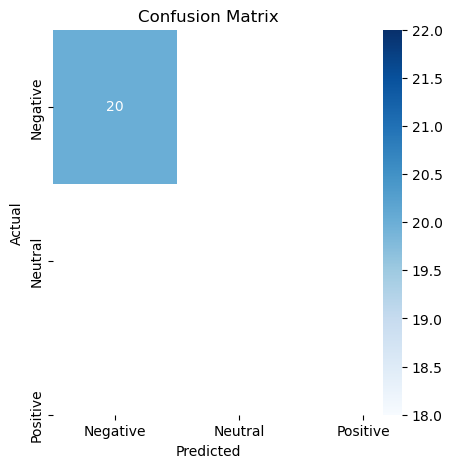

In [35]:
# Vectorize text data
with open("vectorizer.pkl", "rb") as vec_file:
    vectorizer = pickle.load(vec_file)

X = vectorizer.transform(df['clean_text'])  # Transform existing data
y = df['sentiment']  # Labels (-1 = Negative, 0 = Neutral, 1 = Positive)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the trained model
with open("sentiment_model.pkl", "rb") as model_file:
    model = pickle.load(model_file)

# Make predictions
y_pred = model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print Accuracy and Classification Report
print("\n Model Accuracy:", accuracy)
print("\n Classification Report:\n", classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
